In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The config file contains input files and other conditions:
* knowledge based AD gene set
* network: Cheng et al 2019 interactome
* only approved drugs from drugbank

In [2]:
%%bash
cd ../../results/2021-09-28-drugbank-screen-v1
cat knowledge-approved.cfg

[DEFAULT]
dis_genes_fpath = /home/attila/CTNS/results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge
network_fpath = /home/attila/CTNS/resources/PPI/Cheng2019/network.sif
id_mapping_file = /home/attila/CTNS/resources/PPI/geneid_to_symbol.txt
drugbank_prot_fpath = /home/attila/CTNS/results/2021-08-11-drugbank/drugbank-filtered-proteins-approved.csv
drugbank_all_drugs_fpath = /home/attila/CTNS/results/2021-08-11-drugbank/drugbank-all-drugs.csv
asynchronous = yes
max_workers = 7
test_run = no
out_csv = knowledge-approved.csv


Drugbank (approved only) was screened as follows:

## Ranking drugs

Import proximity results and sort them according to $z$, the standardized form of network based distance $d$.  Sorting for $z$ is equivalent with sorting for the $p$-value.  Lower $z$ and $p$ values signify higher ranking drugs.

In [3]:
csv_path = '../../results/2021-09-28-drugbank-screen-v1/knowledge-approved.csv'
results = pd.read_csv(csv_path, index_col='drugbank_id')
results = results.sort_values('z')
results = results.drop('type', axis=1) # type = 'small molecule' for all
columns = ['rank'] + list(results.columns)
results['rank'] = np.arange(results.shape[0], dtype=np.int64) + 1
results = results.reindex(columns=columns)
results.drop('hgnc_id', axis=1).head(30)

,rank,name,groups,symbol,d,avg_d_H0,sdev_d_H0,z,p
drugbank_id,,,,,,,,,
DB01114,1,Chlorpheniramine,approved,HRH1|SLC6A4|SLC6A2|SLC6A3,1.000000,1.972250,0.168204,-5.780199,3.730622e-09
DB06701,2,Dexmethylphenidate,approved|investigational,SLC6A3|SLC6A2|SLC6A4,1.000000,1.960667,0.193814,-4.956633,3.586255e-07
DB01104,3,Sertraline,approved,SLC6A4|SLC6A3|SLC6A2|SLC29A4,1.000000,1.960667,0.193814,-4.956633,3.586255e-07
DB09016,4,Butriptyline,approved,SLC6A4|HRH1|HTR2A,1.000000,1.938333,0.189963,-4.939547,3.915218e-07
DB00476,5,Duloxetine,approved,SLC6A4|SLC6A2|SLC6A3,1.000000,1.962333,0.197830,-4.864442,5.739019e-07
DB00285,6,Venlafaxine,approved,SLC6A4|SLC6A2|SLC6A3,1.000000,1.962333,0.197830,-4.864442,5.739019e-07
DB01105,7,Sibutramine,approved|illicit|investigational|withdrawn,SLC6A2|SLC6A4|SLC6A3,1.000000,1.962333,0.197830,-4.864442,5.739019e-07
DB06700,8,Desvenlafaxine,approved|investigational,SLC6A2|SLC6A4|SLC6A3,1.000000,1.962333,0.197830,-4.864442,5.739019e-07
DB04821,9,Nomifensine,approved|withdrawn,SLC6A2|SLC6A3|MAOB|MAOA|MPO|SLC6A4|SLC18A2,1.285714,1.993286,0.149201,-4.742393,1.056041e-06


The following plot shows that
* distance $d$ tends to increase with $z$ but the increase is not monotonous because $z=(d - \bar{d}_0) / \hat{\sigma}_{d_0}$ therefore $z$ incorporates constraints on $\bar{d}_0$ (`avg_d_H0`) and $\hat{\sigma}_{d_0}$ (sdev_d_H0).  These are constraints on node degree distribution and the number of targets in the simulation of the null distribution $H_0$ of $d$.
* $p$ grows monotonously with $z$: the function $p$ of $z$ is in fact the CDF of the standard normal distribution.

<AxesSubplot:xlabel='z'>

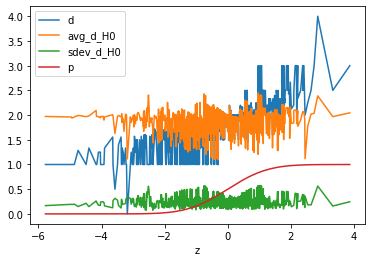

In [4]:
fig, ax = plt.subplots()
results.drop(['rank'], axis=1).plot('z', ax=ax)

## Targets in special interest gene sets

In [5]:
results['symbols'] = results.symbol.str.split('|').apply(set)
results['n_targets'] = results['symbols'].apply(len)

### Agora nominated genes

[Agora](https://agora.ampadportal.org/genes) is a knowledge portal, whose summary reads as:
> Researchers have nominated genes that may be good targets for new Alzheimer's Disease treatment or prevention. These targets have been identified using computational analyses of high-dimensional genomic, proteomic and/or metabolomic data derived from human samples

Here we look at the nearly 600 genes that received 1-4 nominations.  We define the following quantities:
\begin{eqnarray}
\mathrm{sum\_agora\_nomin} &=& \sum_{t \in \{\mathrm{targets} | \mathrm{drug}\}} \# \mathrm{nominations}(t) \\
\mathrm{avg\_agora\_nomin} &=& \frac{\mathrm{sum\_agora\_nomin}}{\# \mathrm{targets} | \mathrm{drug}}
\end{eqnarray}

`avg_agora_nomin` shows how enriched a given drug's targets are in Agora nominations. 

In [6]:
agora = pd.read_csv('../../resources/agora/genes-list.csv', index_col='hgnc_symbol')
agora_genes = set(agora.index)
results['agora_genes'] = results.symbols.apply(lambda x: x.intersection(agora_genes))
sum_agora_nomin = results.agora_genes.apply(lambda s: sum([agora.loc[g, 'nominations'] for g in s]))
results['sum_agora_nomin'] = sum_agora_nomin
results['avg_agora_nomin'] = sum_agora_nomin / results.n_targets

The plots below show $p$, $d$ and a few other variables for each rank.  $d$ tends to increase with rank #, which follows from the relationship between $d$ and $z$ (as we have seen above) combined with the fact that rank is based on $z$.  We expect `avg_agora_nomin` to decrease with rank # but the results do not support that.

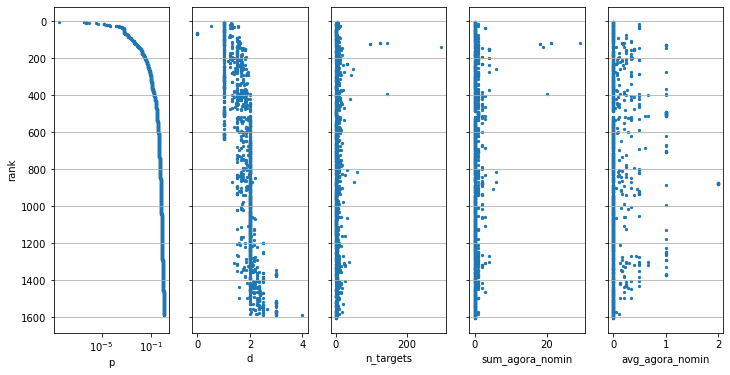

In [7]:
sel_vars = ['p', 'd', 'n_targets', 'sum_agora_nomin', 'avg_agora_nomin']
def vars_vs_rank(sel_vars, results=results):
    fig, ax = plt.subplots(1, len(sel_vars), figsize=(12, 6), sharey=True)
    ax[0].invert_yaxis()
    for axi, var in zip(ax, sel_vars):
        results.plot(kind='scatter', x=var, y='rank', marker='.', ax=axi)
        axi.grid(axis='y')

    ax[0].set_xscale('log')
    return((fig, ax))

fig, ax = vars_vs_rank(sel_vars)

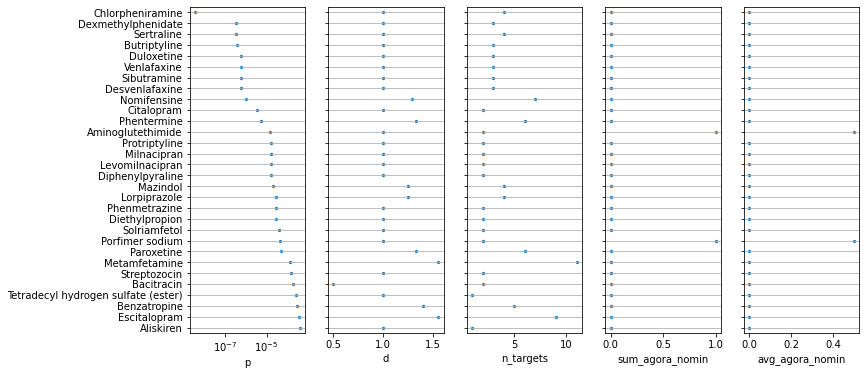

In [8]:
fig, ax = vars_vs_rank(sel_vars, results.iloc[:30])
axi = ax[0]
top_n = 30
axi.set_ylim(top_n + 0.5, 0.5)
ticks = axi.set_yticks(np.arange(1, top_n + 1))
axi.set_yticklabels(results.name[:top_n])
label = axi.set_ylabel('')


In [9]:
%connect_info

{
  "shell_port": 40341,
  "iopub_port": 49563,
  "stdin_port": 48201,
  "control_port": 47097,
  "hb_port": 43403,
  "ip": "127.0.0.1",
  "key": "0b54651a-88e5797bd2d67d07da49995c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-896208d0-1bc6-423d-9ad6-d2be9c31331c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
